<a href="https://colab.research.google.com/github/dvircohen0/projects/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import seaborn as sns
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import tempfile
import numpy as np
import pandas as pd
import os

from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight, shuffle
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv")
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [3]:
neg, pos = np.bincount(df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

df.pop('Time')
df['Log Ammount'] = np.log(df.pop('Amount')+0.001)

v_features = df.iloc[:,0:28].columns

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



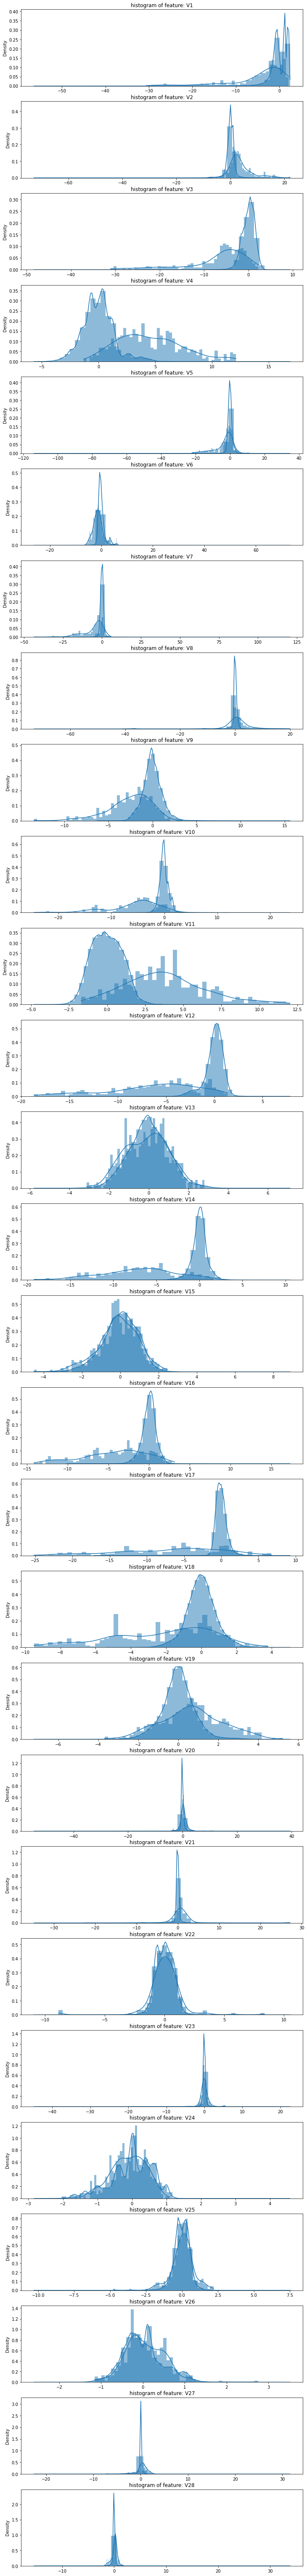

In [4]:
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(df[v_features]):
    ax = plt.subplot(gs[i])
    sns.histplot(df[cn][df.Class == 1], bins=50,kde=True, stat="density", linewidth=0)
    sns.histplot(df[cn][df.Class == 0], bins=50,kde=True, stat="density", linewidth=0)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

In [5]:
features_to_keep=[]
features_to_drop=[]
for i, cn in enumerate(df[v_features]):
    F_m=df[cn][df.Class == 1].mean()
    N_m=df[cn][df.Class == 0].mean()
    F_s=df[cn][df.Class == 1].std()
    N_s=df[cn][df.Class == 0].std()
    if abs(F_m-N_m)>1 or abs(F_s-N_s)>1:
        features_to_keep.append(cn)
    else: features_to_drop.append(cn)
        
print("features to keep: ",features_to_keep)
print("features to drop: ",features_to_drop)

features to keep:  ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V21']
features to drop:  ['V13', 'V15', 'V19', 'V20', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']


In [6]:
df=df.drop(features_to_drop,axis =1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V14,V16,V17,V18,V21,Class,Log Ammount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,-0.018307,0,5.008105
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.225775,0,0.989913
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,0.247998,0,5.936641
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-0.108300,0,4.816249
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,-0.009431,0,4.248367


In [7]:
scaler = StandardScaler()

y=df['Class'].to_numpy()
X=df.drop(['Class'],axis=1)
X = scaler.fit_transform(X)
X = np.clip(X, -5, 5)


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    shuffle = True,
                                                    test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    shuffle = True,
                                                    stratify=y_train, 
                                                    test_size=0.2)

In [8]:
METRICS = [keras.metrics.TruePositives(name='tp'),
          keras.metrics.FalsePositives(name='fp'),
          keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
          keras.metrics.AUC(name='prc', curve='PR')]


def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
    
  model = keras.Sequential([
          keras.layers.Dense(16, activation='relu',
                             input_shape=(X_train.shape[-1],)),
          keras.layers.Dropout(0.5),
          keras.layers.Dense(1, activation='sigmoid',
                             bias_initializer=output_bias)])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [9]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [10]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [13]:
pos = len(df[df.Class==1])
neg = len(df[df.Class==0])
initial_bias = np.log([pos/neg])

model = make_model(output_bias=initial_bias)
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                304       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [14]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [15]:
base_model = make_model()
base_model.load_weights(initial_weights)
baseline_history = base_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val))

Epoch 1/100
90/90 [==============================] - 6s 17ms/step - loss: 0.0271 - tp: 10.6813 - fp: 269.6374 - tn: 93708.8462 - fn: 151.4066 - accuracy: 0.9947 - precision: 0.0321 - recall: 0.0559 - auc: 0.7011 - prc: 0.0095 - val_loss: 0.0090 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 45490.0000 - val_fn: 79.0000 - val_accuracy: 0.9983 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9209 - val_prc: 0.4589
Epoch 2/100
90/90 [==============================] - 1s 8ms/step - loss: 0.0113 - tp: 32.3297 - fp: 27.9560 - tn: 93946.8462 - fn: 133.4396 - accuracy: 0.9982 - precision: 0.4623 - recall: 0.1709 - auc: 0.8139 - prc: 0.1859 - val_loss: 0.0061 - val_tp: 25.0000 - val_fp: 6.0000 - val_tn: 45484.0000 - val_fn: 54.0000 - val_accuracy: 0.9987 - val_precision: 0.8065 - val_recall: 0.3165 - val_auc: 0.9263 - val_prc: 0.6969
Epoch 3/100
90/90 [==============================] - 1s 8ms/step - loss: 0.0075 - tp: 55.6264 - fp: 13.8352 - tn: 93968.3297 - fn: 102.7802 -


Legitimate Transactions Detected (True Negatives):  56853
Legitimate Transactions Incorrectly Detected (False Positives):  11
Fraudulent Transactions Missed (False Negatives):  18
Fraudulent Transactions Detected (True Positives):  80
Total Fraudulent Transactions:  98


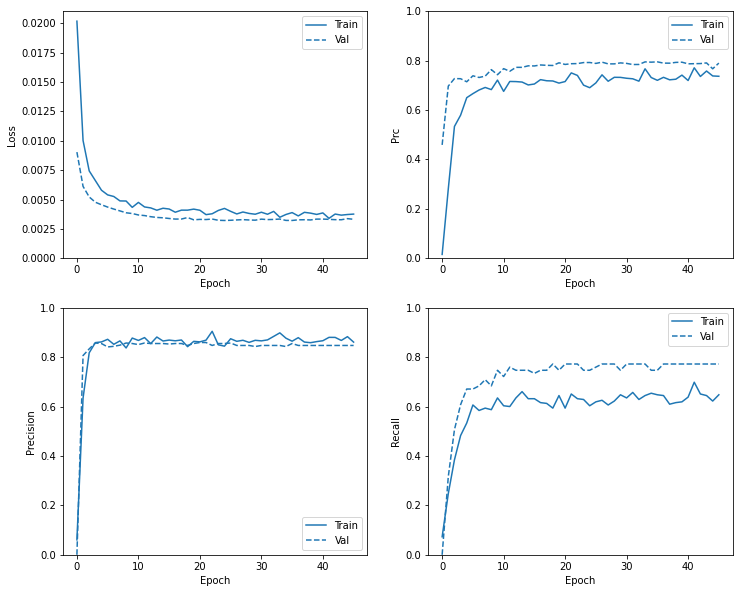

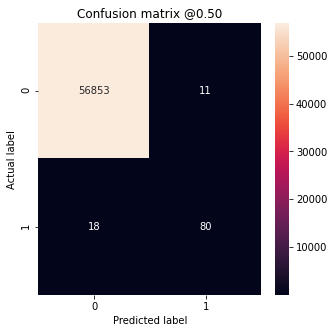

In [16]:
plot_metrics(baseline_history)

train_predictions_baseline = base_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = base_model.predict(X_test, batch_size=BATCH_SIZE)
baseline_results = base_model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

**weighted Model**

In [17]:
class_weights = dict(zip(np.unique(y_train),
                     class_weight.compute_class_weight('balanced', np.unique(y_train), 
                      y_train))) 

weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val),
    # The class weights go here
    class_weight=class_weights)

Epoch 1/100
90/90 [==============================] - 3s 17ms/step - loss: 1.7120 - tp: 116.9560 - fp: 778.8242 - tn: 150067.4945 - fn: 139.2967 - accuracy: 0.9946 - precision: 0.1836 - recall: 0.4870 - auc: 0.8411 - prc: 0.1689 - val_loss: 0.0270 - val_tp: 53.0000 - val_fp: 197.0000 - val_tn: 45293.0000 - val_fn: 26.0000 - val_accuracy: 0.9951 - val_precision: 0.2120 - val_recall: 0.6709 - val_auc: 0.9294 - val_prc: 0.3837
Epoch 2/100
90/90 [==============================] - 1s 8ms/step - loss: 0.6702 - tp: 97.6484 - fp: 1441.8901 - tn: 92541.5385 - fn: 59.4945 - accuracy: 0.9846 - precision: 0.0583 - recall: 0.5741 - auc: 0.8952 - prc: 0.1427 - val_loss: 0.0369 - val_tp: 68.0000 - val_fp: 292.0000 - val_tn: 45198.0000 - val_fn: 11.0000 - val_accuracy: 0.9934 - val_precision: 0.1889 - val_recall: 0.8608 - val_auc: 0.9308 - val_prc: 0.5559
Epoch 3/100
90/90 [==============================] - 1s 8ms/step - loss: 0.5336 - tp: 111.4286 - fp: 2119.7143 - tn: 91865.1429 - fn: 44.2857 - accur

loss :  0.05355863645672798
tp :  84.0
fp :  628.0
tn :  56236.0
fn :  14.0
accuracy :  0.9887293577194214
precision :  0.11797752976417542
recall :  0.8571428656578064
auc :  0.9537193179130554
prc :  0.6786273121833801

Legitimate Transactions Detected (True Negatives):  56236
Legitimate Transactions Incorrectly Detected (False Positives):  628
Fraudulent Transactions Missed (False Negatives):  14
Fraudulent Transactions Detected (True Positives):  84
Total Fraudulent Transactions:  98


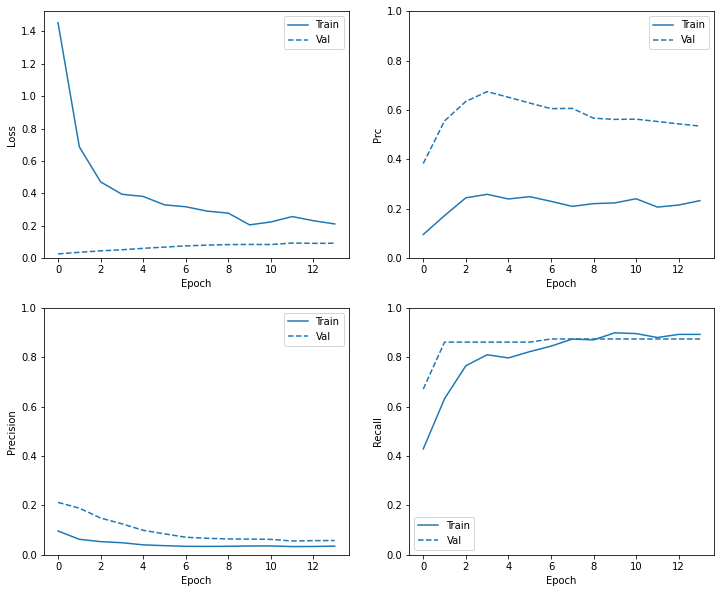

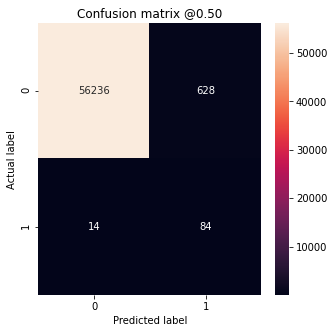

In [18]:
plot_metrics(weighted_history)

train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE) 
test_predictions_weighted = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

**Resampled Model**

In [19]:
oversample = RandomOverSampler(sampling_strategy='minority')

X_over, y_over = oversample.fit_resample(X_train, y_train)
X_over, y_over = shuffle(X_over, y_over)

resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])


resampled_history = resampled_model.fit(
    X_over, y_over,
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/1000
20/20 [==============================] - 9s 395ms/step - loss: 0.9351 - tp: 83038.2381 - fp: 85978.1905 - tn: 70488.6190 - fn: 16755.7143 - accuracy: 0.6281 - precision: 0.4865 - recall: 0.8224 - auc: 0.7976 - prc: 0.6986 - val_loss: 1.3437 - val_tp: 78.0000 - val_fp: 42480.0000 - val_tn: 3010.0000 - val_fn: 1.0000 - val_accuracy: 0.0678 - val_precision: 0.0018 - val_recall: 0.9873 - val_auc: 0.8843 - val_prc: 0.0468
Epoch 2/1000
20/20 [==============================] - 7s 355ms/step - loss: 0.7839 - tp: 90060.0000 - fp: 80725.0952 - tn: 18895.7143 - fn: 9617.9524 - accuracy: 0.5431 - precision: 0.5251 - recall: 0.9012 - auc: 0.7761 - prc: 0.8161 - val_loss: 1.1753 - val_tp: 77.0000 - val_fp: 39781.0000 - val_tn: 5709.0000 - val_fn: 2.0000 - val_accuracy: 0.1270 - val_precision: 0.0019 - val_recall: 0.9747 - val_auc: 0.9120 - val_prc: 0.1092
Epoch 3/1000
20/20 [==============================] - 7s 351ms/step - loss: 0.6825 - tp: 91385.4762 - fp: 73670.0476 - tn: 25884.0000

loss :  0.16677574813365936
tp :  89.0
fp :  1569.0
tn :  55295.0
fn :  9.0
accuracy :  0.9722973108291626
precision :  0.05367913097143173
recall :  0.9081632494926453
auc :  0.9785456657409668
prc :  0.7185628414154053

Legitimate Transactions Detected (True Negatives):  55295
Legitimate Transactions Incorrectly Detected (False Positives):  1569
Fraudulent Transactions Missed (False Negatives):  9
Fraudulent Transactions Detected (True Positives):  89
Total Fraudulent Transactions:  98


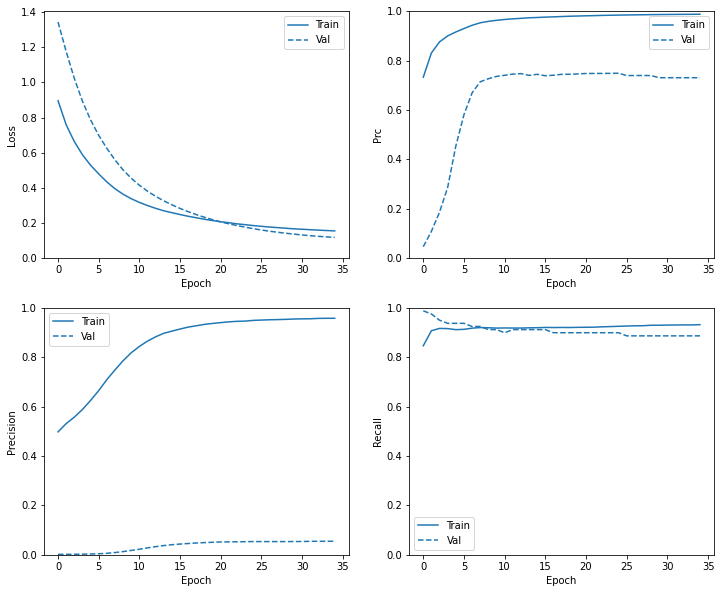

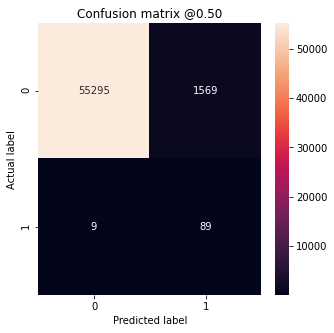

In [20]:
plot_metrics(resampled_history)

train_predictions_resampled = resampled_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(X_test, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(X_test, y_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_resampled)

In [21]:
smote = SMOTE()

X_smote, y_smote = smote.fit_resample(X_train, y_train)
X_smote, y_smote = shuffle(X_smote, y_smote)

smote_model = make_model()
smote_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])


smote_history = smote_model.fit(
    X_smote, y_smote,
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/1000
20/20 [==============================] - 9s 401ms/step - loss: 2.1176 - tp: 10205.7143 - fp: 2360.0476 - tn: 154119.0952 - fn: 89575.9048 - accuracy: 0.6654 - precision: 0.7315 - recall: 0.0916 - auc: 0.4861 - prc: 0.4234 - val_loss: 0.0249 - val_tp: 20.0000 - val_fp: 163.0000 - val_tn: 45327.0000 - val_fn: 59.0000 - val_accuracy: 0.9951 - val_precision: 0.1093 - val_recall: 0.2532 - val_auc: 0.8825 - val_prc: 0.0460
Epoch 2/1000
20/20 [==============================] - 7s 346ms/step - loss: 1.4093 - tp: 29386.0000 - fp: 1154.9048 - tn: 98675.7619 - fn: 70082.0952 - accuracy: 0.6332 - precision: 0.9600 - recall: 0.2755 - auc: 0.7870 - prc: 0.8233 - val_loss: 0.0304 - val_tp: 44.0000 - val_fp: 232.0000 - val_tn: 45258.0000 - val_fn: 35.0000 - val_accuracy: 0.9941 - val_precision: 0.1594 - val_recall: 0.5570 - val_auc: 0.9160 - val_prc: 0.2012
Epoch 3/1000
20/20 [==============================] - 7s 349ms/step - loss: 0.9045 - tp: 52663.4762 - fp: 1568.4286 - tn: 98033.7619 

loss :  0.06972739845514297
tp :  87.0
fp :  1052.0
tn :  55812.0
fn :  11.0
accuracy :  0.9813384413719177
precision :  0.07638279348611832
recall :  0.8877550959587097
auc :  0.9578185677528381
prc :  0.5808320045471191

Legitimate Transactions Detected (True Negatives):  55812
Legitimate Transactions Incorrectly Detected (False Positives):  1052
Fraudulent Transactions Missed (False Negatives):  11
Fraudulent Transactions Detected (True Positives):  87
Total Fraudulent Transactions:  98


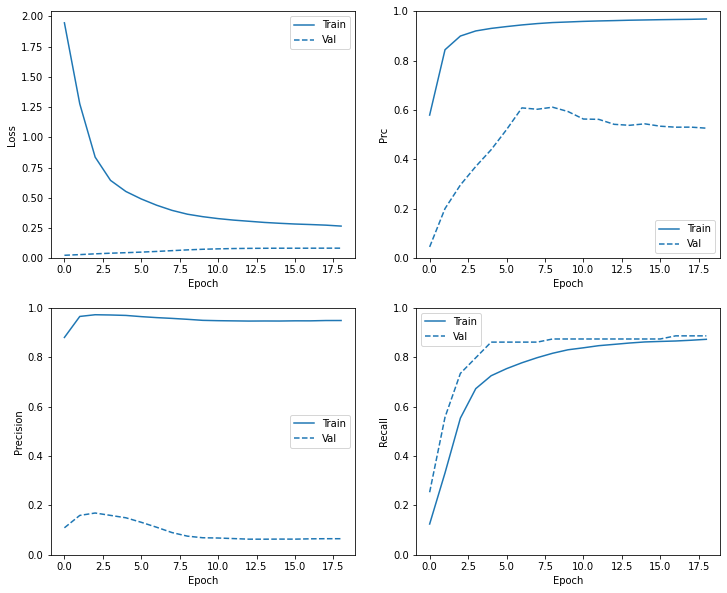

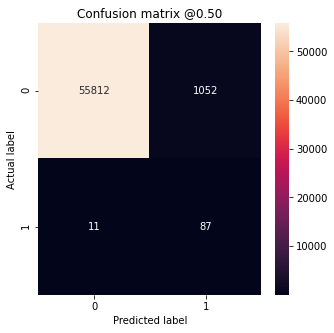

In [22]:
plot_metrics(smote_history)

train_predictions_smote = smote_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_smote = smote_model.predict(X_test, batch_size=BATCH_SIZE)

smote_results = smote_model.evaluate(X_test, y_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(smote_model.metrics_names, smote_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_smote)

In [23]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

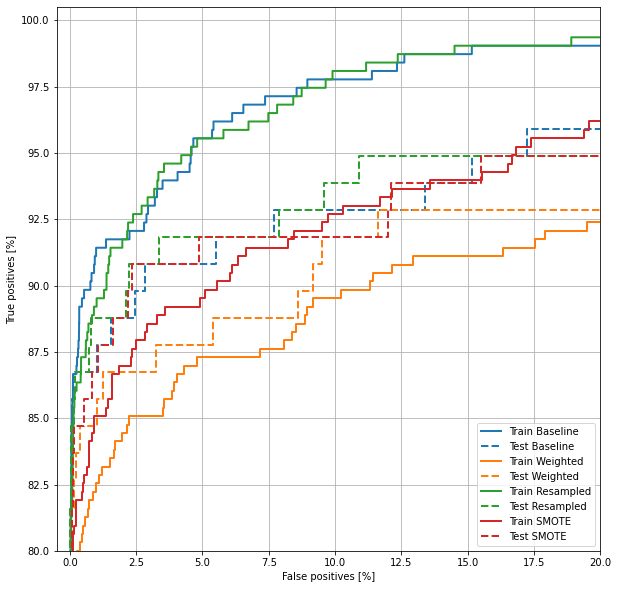

In [24]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", y_train, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", y_test, test_predictions_resampled, color=colors[2], linestyle='--')

plot_roc("Train SMOTE", y_train, train_predictions_smote, color=colors[3])
plot_roc("Test SMOTE", y_test, test_predictions_smote, color=colors[3], linestyle='--')

plt.legend(loc='lower right')